In [1]:
import pandas as pd
import numpy as np

from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn import neighbors

import matplotlib.pyplot as plt

In [2]:
stations = pd.read_csv('data/station.csv')

In [3]:
trips = pd.read_csv('data/trip_train.csv', parse_dates=['start_date','end_date'], infer_datetime_format=True, low_memory=False)

In [4]:
weather = pd.read_csv('data/weather.csv', parse_dates=['date'], infer_datetime_format=True)

In [5]:
trips['start_time'] = trips.start_date.dt.hour
trips['start_date'] = pd.to_datetime(trips.start_date.dt.date)

In [6]:
trips.rename(columns = {'start_date':'date'}, inplace=True)

In [7]:
d = {'city': ['San Jose','Redwood City','Mountain View', 'Palo Alto', 'San Francisco'],\
         'zip_code':[95113,94063,94041,94301,94107]}
city_zip_codes = pd.DataFrame(data = d)

In [8]:
stations = pd.merge(stations, city_zip_codes, on='city', how='left')

In [9]:
# se agrega el zip_code de la ciudad de la start station a cada viaje
stations_to_join = stations.loc[:,['id','zip_code']]
stations_to_join.columns = ['start_station_id','city_zip_code']

trips = pd.merge(trips, stations_to_join, on='start_station_id', how='left')

In [11]:
weather.rename(columns={'zip_code':'city_zip_code'}, inplace=True)

In [12]:
data = pd.merge(trips, weather, on=['date','city_zip_code'], how='inner')

In [13]:
data.columns

Index(['id', 'duration', 'date', 'start_station_name', 'start_station_id',
       'end_date', 'end_station_name', 'end_station_id', 'bike_id',
       'subscription_type', 'zip_code', 'start_time', 'city_zip_code',
       'max_temperature_f', 'mean_temperature_f', 'min_temperature_f',
       'max_dew_point_f', 'mean_dew_point_f', 'min_dew_point_f',
       'max_humidity', 'mean_humidity', 'min_humidity',
       'max_sea_level_pressure_inches', 'mean_sea_level_pressure_inches',
       'min_sea_level_pressure_inches', 'max_visibility_miles',
       'mean_visibility_miles', 'min_visibility_miles', 'max_wind_Speed_mph',
       'mean_wind_speed_mph', 'max_gust_speed_mph', 'precipitation_inches',
       'cloud_cover', 'events', 'wind_dir_degrees'],
      dtype='object')

In [14]:
# suscriber = 1
# customer = 0

data['subscription_type'] = data.loc[:,['subscription_type']].applymap(lambda x: 1 if x == 'Subscriber' else 0)

In [15]:
data = pd.concat([data,pd.get_dummies(data['events'])],axis=1)
data.drop(labels=['events'],axis=1,inplace=True)

In [17]:
data['start_day'] = data['date'].dt.dayofweek
data['end_day'] = data['end_date'].dt.dayofweek
data['end_time'] = data['end_date'].dt.hour
data['month'] = data['date'].dt.month
data['year'] = data['date'].dt.year

In [18]:
data.drop(labels=['id','start_station_name','end_station_name','precipitation_inches','date','end_date','zip_code'], axis=1, inplace=True)
data.columns

Index(['duration', 'start_station_id', 'end_station_id', 'bike_id',
       'subscription_type', 'start_time', 'city_zip_code', 'max_temperature_f',
       'mean_temperature_f', 'min_temperature_f', 'max_dew_point_f',
       'mean_dew_point_f', 'min_dew_point_f', 'max_humidity', 'mean_humidity',
       'min_humidity', 'max_sea_level_pressure_inches',
       'mean_sea_level_pressure_inches', 'min_sea_level_pressure_inches',
       'max_visibility_miles', 'mean_visibility_miles', 'min_visibility_miles',
       'max_wind_Speed_mph', 'mean_wind_speed_mph', 'max_gust_speed_mph',
       'cloud_cover', 'wind_dir_degrees', 'Fog', 'Fog-Rain', 'Rain',
       'Rain-Thunderstorm', 'rain', 'start_day', 'end_day', 'end_time',
       'month', 'year'],
      dtype='object')

In [19]:
data.dtypes

duration                            int64
start_station_id                    int64
end_station_id                      int64
bike_id                             int64
subscription_type                   int64
start_time                          int64
city_zip_code                       int64
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               

# Dimension Reduction

In [20]:
data = data.dropna(how='any').reset_index(drop=True)
data.shape

(533260, 37)

In [21]:
target_values = data['duration']
data.drop(labels='duration', axis=1, inplace=True)

In [22]:
u,s,v = np.linalg.svd(data.as_matrix(),full_matrices=0)

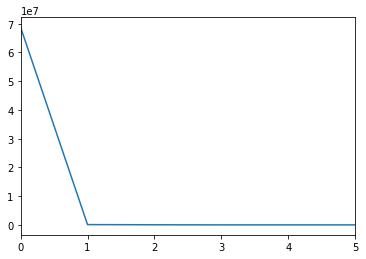

In [23]:
%matplotlib inline
plt.xlim(xmax=5)
plt.plot(s)

# KNN 

In [24]:
reduced_data = u[:,0:3]

In [39]:
# finding best hyperparameters for knn with grid search and cross-validation

possible_k = [2, 3, 10, 100]
possible_metric = ['euclidean', 'manhattan']
number_of_splits = 5
kf = KFold(n_splits=number_of_splits)
best_precision = 0
best_k = 0
best_metric = ''

for k in possible_k:
    for metric in possible_metric:

        precision = 0
        
        for train,test in kf.split(reduced_data):

            train_set_x = reduced_data[train]  # los train_set son para hacer el fit con el knn
            train_set_y = target_values[train]

            test_set_x = reduced_data[test]  # los test_set_x son los que seran predecidos
            test_set_y = target_values[test]  # los test_set_y son los valores de duracion que deberian dar como resultado

            knn = neighbors.KNeighborsRegressor(n_neighbors=k, metric=metric)
            knn.fit(train_set_x, train_set_y)

            m = train_set_x.shape[0] # number of observations
            
            pred = knn.predict(test_set_x)
            precision += sum(np.isclose(pred,test_set_y, rtol=.25)) / m

        precision /=  number_of_splits
        if (precision > best_precision):
            best_precision = precision
            best_k = k
            best_metric = metric

In [40]:
print('we got: ' , best_precision * 100, '% of precision with k:', best_k,'and metric: ', best_metric)

we got:  6.63827213742 % of precision with k: 3 and metric:  manhattan


# Decision Tree Regressor

In [30]:
possible_depth = [i for i in range(1,11)]

1
2
3
4
5
6
7
8
9
10


In [32]:
best_depth = 0
best_precision = 0

number_of_split = 5

kf = KFold(n_splits=number_of_split)

for current_depth in possible_depth:
    
    regr_1 = DecisionTreeRegressor(max_depth=current_depth)
    
    precision = 0
    
    for train,test in kf.split(data):

        x_train = data.iloc[train,:]
        y_train = target_values[train]
        
        x_test = data.iloc[test,:]
        y_test = target_values[test]
        
        regr_1.fit(x_train, y_train)

        y_pred = regr_1.predict(x_test)

        precision += sum(np.isclose(y_pred, y_test, rtol=.15)) / float(x_train.shape[0])

    precision /= number_of_split
    
    if (precision > best_precision):
        
        best_precision = precision
        best_depth = current_depth

In [35]:
print (best_depth, best_precision)

6 0.249928271387


In [ ]:
%matplotlib inline
plt.figure(figsize=(15,8))
plt.scatter(x=range(len(y_1)),y=y_1)

In [ ]:
plt.figure(figsize=(15,8))
plt.ylim(0,531240)
plt.scatter(x=range(len(Y_test)),y=Y_test)

In [ ]:
regr_1.score(X,)